TODO:

- run logs for 400k, 600k and test generalization of these models
- might need some additional information about time between interrupts (additional column)

Status:

- there's signal in the spectrum (distribution of eigenvalues) about the true latency
- question: what's the interpretation of this? do we need one (it would be nice but not necessary for predictions)?

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('lat_eig.csv')
df.head()

,desc,avg,std,min,5th,10th,50th,90th,95th,99th,...,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13
0,0_100_0x1d00_135_200000,100.3,31.5,37.4,51.3,57.3,100.6,141.1,151.5,171.5,...,0.440060,0.000859,0.000327,0.000053,0.000017,0.000011,7.398808e-06,2.850891e-06,1.803686e-07,9.683146e-08
1,0_10_0x1d00_135_200000,49.1,4.6,34.0,42.2,43.3,48.5,55.5,58.5,64.5,...,0.162246,0.003525,0.000319,0.000128,0.000045,0.000021,3.140831e-06,1.732030e-07,3.880479e-08,1.932744e-13
2,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.424921,0.066377,0.001418,0.000451,0.000151,0.000032,1.899372e-05,2.834952e-07,1.581454e-06,1.421811e-06
3,0_40_0x1d00_135_200000,60.9,12.9,34.0,43.8,45.9,58.7,79.1,83.4,88.1,...,0.505817,0.004241,0.000343,0.000143,0.000019,0.000007,9.731156e-07,4.427437e-07,2.197987e-07,1.825507e-09
4,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.411281,0.021113,0.003975,0.000559,0.000281,0.000061,1.589944e-05,6.504408e-06,6.299850e-07,1.045465e-06


In [3]:
df['itr'] = df['desc'].apply(lambda x: int(x.split('_')[1]))
df['dvfs'] = df['desc'].apply(lambda x: int(x.split('_')[2], base=16))

In [4]:
df.head()

,desc,avg,std,min,5th,10th,50th,90th,95th,99th,...,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,itr,dvfs
0,0_100_0x1d00_135_200000,100.3,31.5,37.4,51.3,57.3,100.6,141.1,151.5,171.5,...,0.000327,0.000053,0.000017,0.000011,7.398808e-06,2.850891e-06,1.803686e-07,9.683146e-08,100,7424
1,0_10_0x1d00_135_200000,49.1,4.6,34.0,42.2,43.3,48.5,55.5,58.5,64.5,...,0.000319,0.000128,0.000045,0.000021,3.140831e-06,1.732030e-07,3.880479e-08,1.932744e-13,10,7424
2,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.001418,0.000451,0.000151,0.000032,1.899372e-05,2.834952e-07,1.581454e-06,1.421811e-06,350,7424
3,0_40_0x1d00_135_200000,60.9,12.9,34.0,43.8,45.9,58.7,79.1,83.4,88.1,...,0.000343,0.000143,0.000019,0.000007,9.731156e-07,4.427437e-07,2.197987e-07,1.825507e-09,40,7424
4,0_350_0x1d00_135_200000,244.2,102.6,41.1,82.7,103.7,245.5,381.3,400.0,437.7,...,0.003975,0.000559,0.000281,0.000061,1.589944e-05,6.504408e-06,6.299850e-07,1.045465e-06,350,7424


In [5]:
eig_cols = [c for c in df if c.find('eig')>-1]
eig_cols

['eig_0',
 'eig_1',
 'eig_2',
 'eig_3',
 'eig_4',
 'eig_5',
 'eig_6',
 'eig_7',
 'eig_8',
 'eig_9',
 'eig_10',
 'eig_11',
 'eig_12',
 'eig_13']

In [6]:
#should add to n where correlation matrix is n x n since Tr(C) = n
df[eig_cols].sum(axis=1).unique()

array([14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14.])

In [7]:
#correlation matrix C = X^T X i.e. positive definite -> eigenvalues should be positive
(df[eig_cols] <= 0).sum().sum()

0

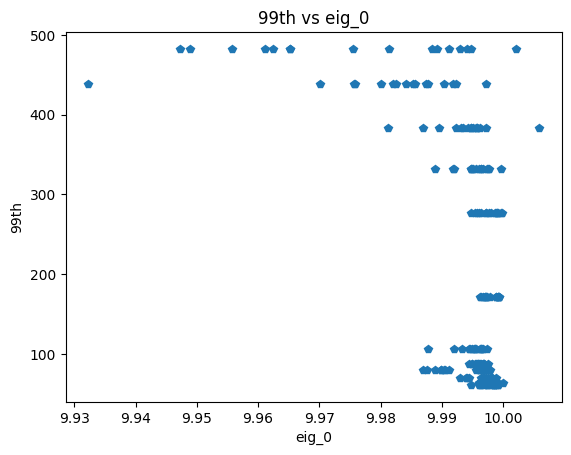

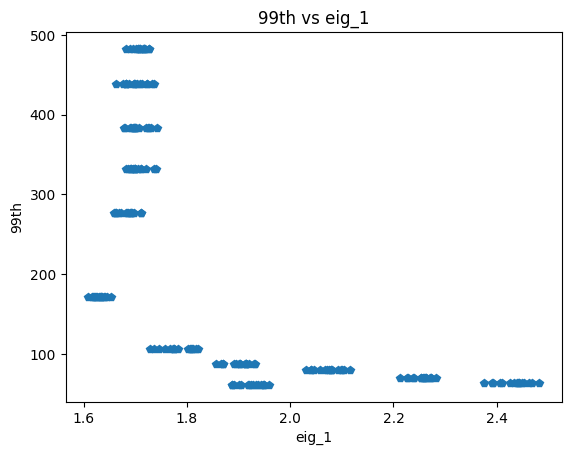

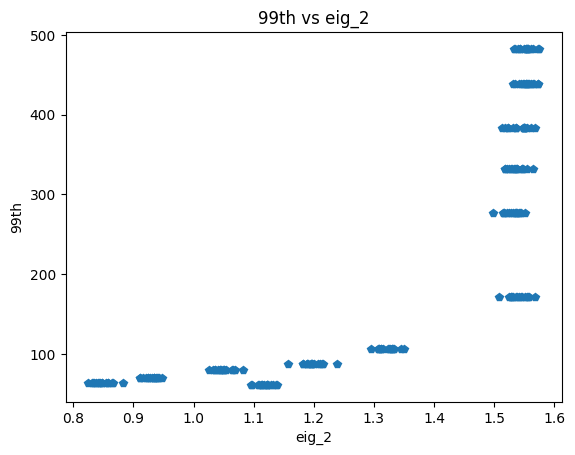

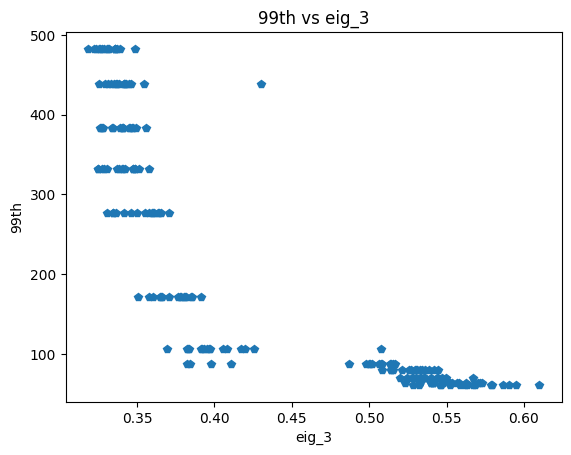

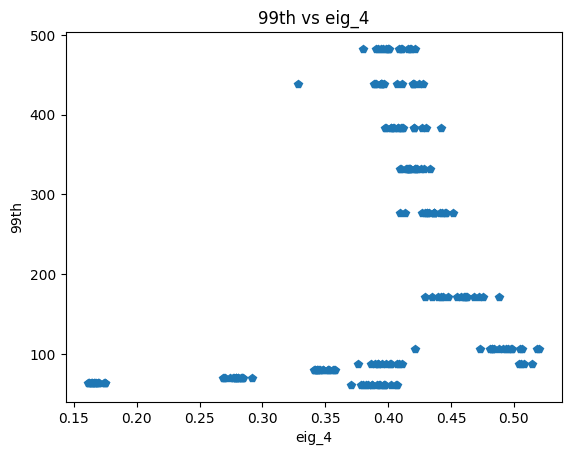

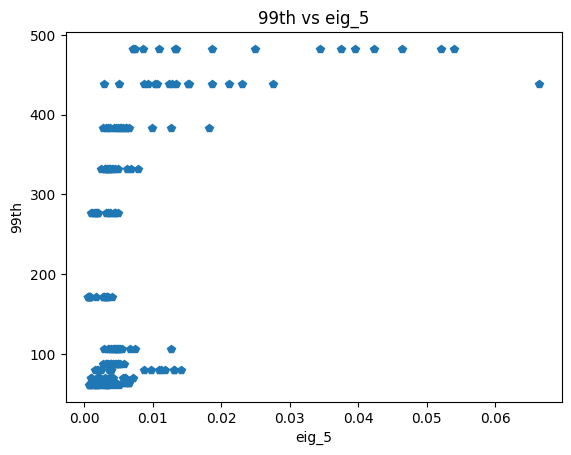

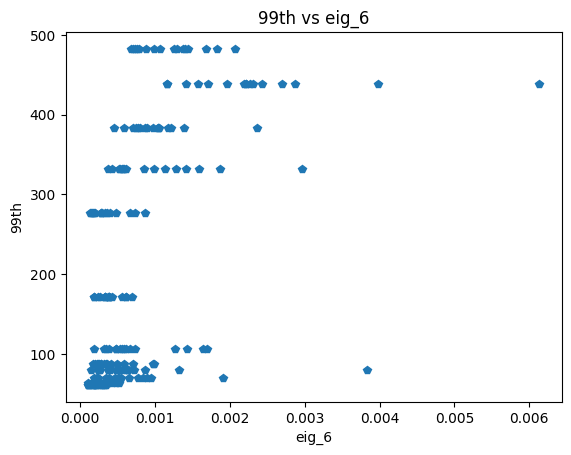

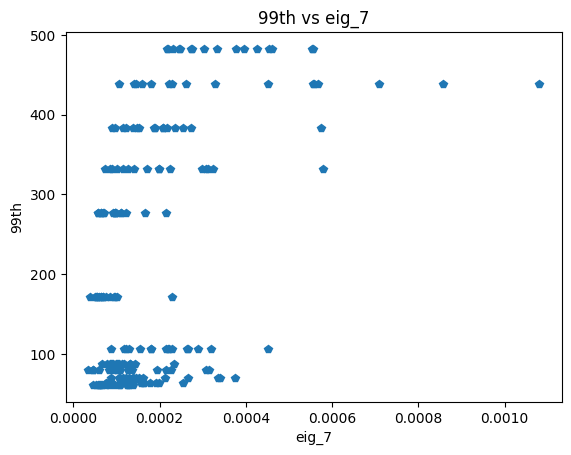

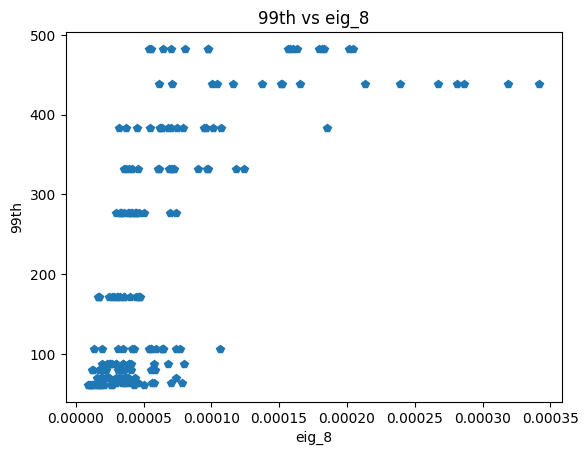

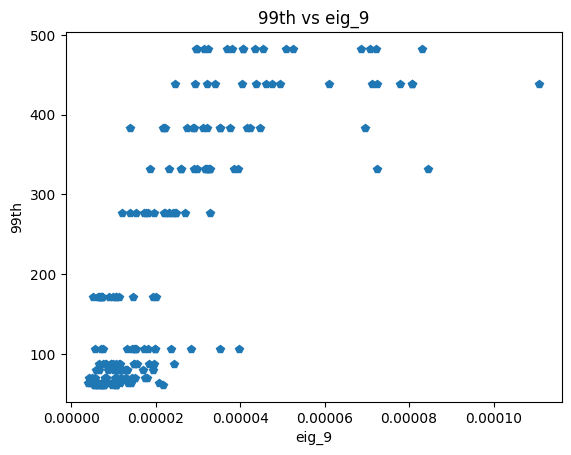

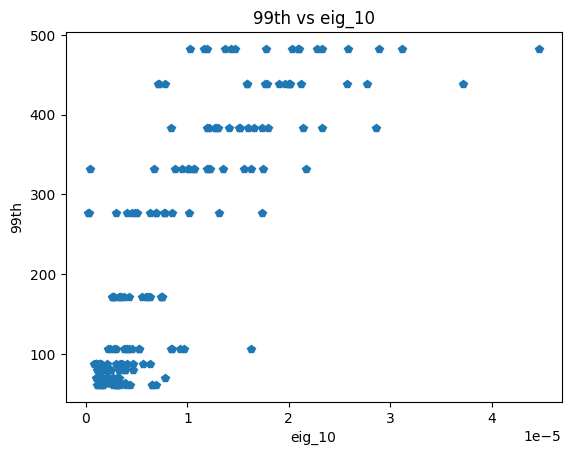

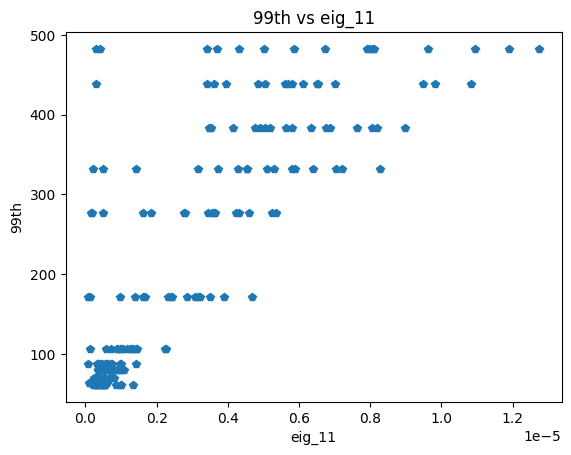

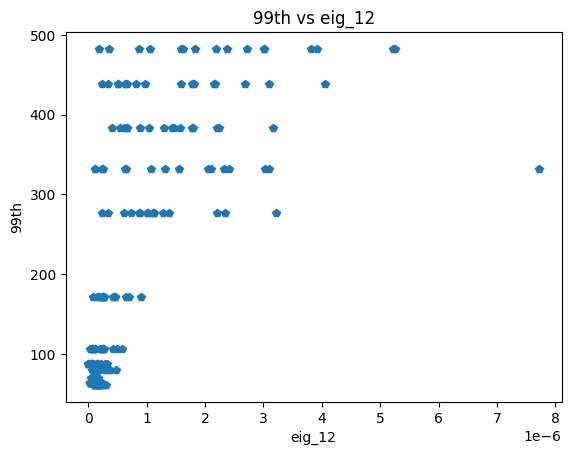

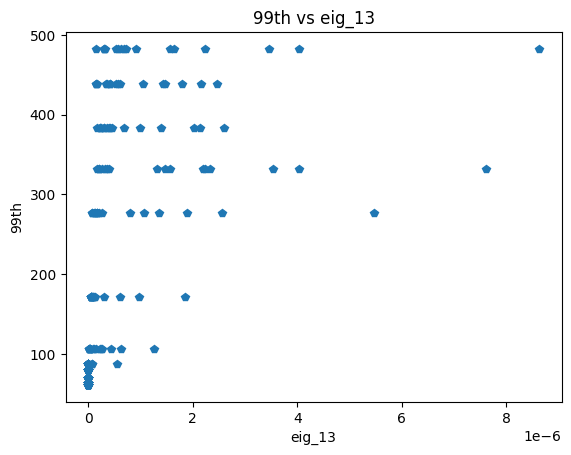

In [8]:
#plot kth eigenvalue vs latency
lat_col = '99th'
for c in eig_cols:
    plt.figure()
    plt.plot(df[c], df[lat_col], 'p')
    plt.xlabel(c)
    plt.ylabel(lat_col)
    plt.title(f'{lat_col} vs {c}')

In [58]:
n_iter = 10

scale = True
ratios = True
log = False

scorer = r2_score

def run_exp(model,
            df,
            scale=True, 
            ratios=True, 
            log=False, 
            n_iter=10, 
            scorer=r2_score,
            plot=False):

    score_list, model_list = [], []

    for i in range(n_iter):
        #split into train and test sets
        df_train, df_test = train_test_split(df, train_size=0.7)
        
        if i==0: print(df_train.shape, df_test.shape)

        #define features to be eigenvalues
        df_train_feats = df_train[eig_cols].copy()
        df_test_feats = df_test[eig_cols].copy()
    
        #define latency column to be target
        df_train_y = df_train[lat_col].copy()
        df_test_y = df_test[lat_col].copy()
    
        #
        if ratios: #features are scaled by highest eigenvalue (assumed to be eig_0 although should check this)
            for c in eig_cols:
                df_train_feats[c] = df_train_feats[c] / df_train_feats['eig_0']
                df_test_feats[c] = df_test_feats[c] / df_test_feats['eig_0']

            df_train_feats.drop('eig_0', axis=1, inplace=True)
            df_test_feats.drop('eig_0', axis=1, inplace=True)

        feat_col_names = df_train_feats.columns

        if log: #take logs of features to suppress scales
            df_train_feats = df_train_feats.apply(lambda x: np.log(x), axis=1)
            df_test_feats = df_test_feats.apply(lambda x: np.log(x), axis=1)

        if scale: #standard normalization for linear models
            scaler = StandardScaler(with_mean=True, with_std=True)
            df_train_feats = scaler.fit_transform(df_train_feats)
            df_test_feats = scaler.transform(df_test_feats)

        model.fit(df_train_feats, df_train_y)

        pred_train = model.predict(df_train_feats)
        pred_test = model.predict(df_test_feats)

        labels_train = df_train_y
        labels_test = df_test_y
        
        if plot:
            plt.figure(figsize=(5,3))
            plt.plot(labels_train, pred_train, 'p', label='train')
            plt.plot(labels_test, pred_test, 'p', label='test')
            plt.plot(labels_train, labels_train, '-')
            plt.xlim((0, 500))
            plt.ylim((0, 500))
            plt.legend()
            plt.grid()
            plt.xlabel('labels')
            plt.ylabel('preds')

        train_score = scorer(pred_train, labels_train)
        test_score = scorer(pred_test, labels_test)

        score_list.append((train_score, test_score))
    
    return score_list, model, feat_col_names #this is the last trained model but ok for now

In [57]:
for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():

    score_list, model, feat_col_names = run_exp(model,
                                                df,
                                                scale=True, 
                                                ratios=True, 
                                                log=False, 
                                                n_iter=10, 
                                                scorer=r2_score,
                                                plot=False) #change plot->True to see plots

    score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
    print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

(134, 26) (58, 26)
model=LinearRegression() 0.932--0.945--0.958

(134, 26) (58, 26)
model=Lasso() 0.916--0.936--0.956

(134, 26) (58, 26)
model=Ridge() 0.939--0.952--0.964

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.883--0.922--0.961

(134, 26) (58, 26)
model=RandomForestRegressor() 0.933--0.952--0.972



In [26]:
sorted(zip(feat_col_names, 100*model.feature_importances_), 
       key=operator.itemgetter(1), 
       reverse=True)

[('eig_3', 57.946172913373196),
 ('eig_2', 12.698861702476641),
 ('eig_9', 7.448091521875128),
 ('eig_5', 4.42165539203103),
 ('eig_1', 4.009670558864533),
 ('eig_13', 3.6353955758793792),
 ('eig_11', 3.563865731341915),
 ('eig_6', 1.7578107484383074),
 ('eig_10', 1.5891184715230722),
 ('eig_4', 1.3039512261882837),
 ('eig_12', 0.9848825740652002),
 ('eig_8', 0.3289205367286407),
 ('eig_7', 0.3116030472146668)]